
# Privkit Tutorial


This notebook provides a tour of some of Privkit's features related to location data including how to:
- load datasets
- get dataset statistics
- apply privacy-preserving mechanisms
- apply adversary attacks
- perform ppm and attack analysis through suitable metrics
- visualize the obtained results


In [2]:
import privkit as pk

## Loading Data

Privkit provides access to the following mobility datasets: 
- cabspotting - mobility traces of taxi cabs in San Francisco, USA
- geolife - mobility data collected in Beijing, China

In the current tutorial, we will load data from the GeolifeDataset as follows.

In [3]:
# contains multiple constant variables that result in a less verbose coding
from privkit.utils import constants

In [4]:
# loading geolife dataset
dataset = pk.datasets.GeolifeDataset()
dataset.load_dataset()

Loading the geolife dataset
Dataset loaded from ./input/data/geolife.pkl


In [5]:
location_data = dataset.data
location_data.data = location_data.data[:100]  # To limit the number of records

In [6]:
# prints data summary, specifying the number of users, trajectories, and other statistics
location_data.print_data_summary()

# prints statistics of data by user, specifying the number of trajectories, points, and other statistics per user
location_data.print_statistics_by_user()


Location Data contains:
#users: 1
#trajectories: 1
The total number of points is 100, with the smallest trajectory having 100 points and the biggest 100
The average number of points per trajectory is 100.0
The average of update rate is 4.96 s
Spawning from 2008-10-23 02:53:04 till 2008-10-23 03:01:20
Covering the bounding box [39.984303, 39.984708, 116.302094, 116.31845]

Location Data contains 1 users:
User 0 has 100 points in 1 trajectories (average=100.0) spawning from 2008-10-23 02:53:04 to 2008-10-23 03:01:20 covering the bounding box [39.984303, 39.984708, 116.302094, 116.31845]


## Applying a Privacy-Preserving Mechanism

The following list contains some of the PPMs implemented as well as a quick explanation of each.
- **Planar Laplace**: consists of adding 2-dimensional Laplacian noise centered at the exact user location. The Laplacian distribution depends on a privacy parameter epsilon defined as ε=l/r, which means that a privacy level l is guaranteed within a radius r.

- **Adaptive Geo-Indistinguishability**: uses the Planar Laplace mechanism as baseline, but dynamically adapts the privacy parameter epsilon according to the correlation between the current and the past locations.

- **Clustering Geo-Indistinguishability**: consists of creating obfuscation clusters to aggregate nearby locations into a single obfuscated location. This obfuscated location is produced by Planar Laplace.

- **Velocity-Aware Geo-Indistinguishability**: uses the Planar Laplace mechanism as baseline, but dynamically adapts the privacy parameter epsilon according to the user velocities as well as the reporting speed.

In [7]:
# initialize and apply Planar Laplace
epsilon = 0.016
planar_laplace = pk.PlanarLaplace(epsilon=epsilon)
location_data_pl = planar_laplace.execute(location_data)

# initialize and apply Clustering Geo-Ind
import numpy as np
clustering = pk.ClusteringGeoInd(r=np.log(4)/epsilon, epsilon=epsilon)
location_data_cgi = clustering.execute(location_data)

# initialize and apply Adaptive Geo-Ind
adaptive = pk.AdaptiveGeoInd(epsilon=epsilon, ws=2)
location_data_agi = adaptive.execute(location_data)

# initialize and apply Velocity-Aware Geo-Ind
va_gi = pk.VAGI(epsilon=epsilon, m=10)
location_data_vagi = adaptive.execute(location_data)

## Applying an Adversary Attack


Applying attacks to data obfuscated with VA-GI:

In [8]:
# initialize and apply OptimalHW
optHW = pk.OptimalHW(epsilon=epsilon)
location_data_opthw = optHW.execute(location_data)

# initialize and apply OmniHW
omniHW = pk.OmniHW(epsilon=epsilon)
location_data_omnihw = omniHW.execute(location_data)

Creating a grid from locations with 250m squared cells.
Computing the locationstamp and timestamp for an interval of 60s
Dividing data into train and test data with a 0.2 ratio for testing.


## Mechanism analysis and Visualization of results

Perform analysis to VA-GI (PPM) and omniHW (attack):

In [9]:
from privkit.utils import plot_utils

In [10]:
ppm = va_gi
attack = omniHW

Statistics of Quality Loss:

Median: 996.9771887627346

Mean: 1200.081493662923



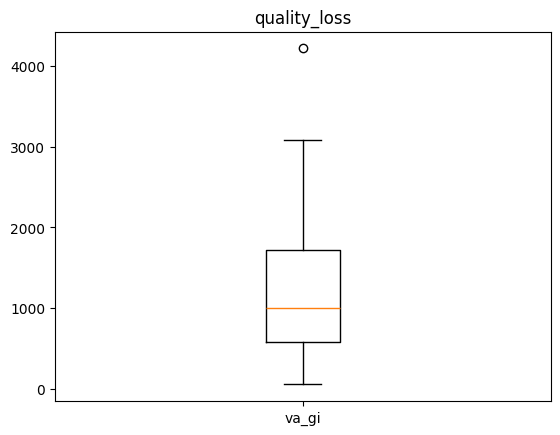

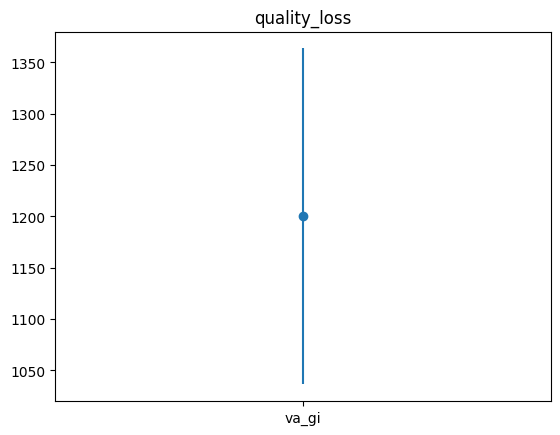

In [11]:
quality_loss = pk.QualityLoss()
location_data = quality_loss.execute(location_data)

plot_utils.boxplot(labels=[ppm.PPM_ID], values=quality_loss.values, title=quality_loss.METRIC_ID, show=True)
plot_utils.plot_errorbar(x=[ppm.PPM_ID], y=quality_loss.values, title=quality_loss.METRIC_ID, show=True)

Statistics of Adversary Error:

Median: 496.14556855439093

Mean: 568.0545445030544



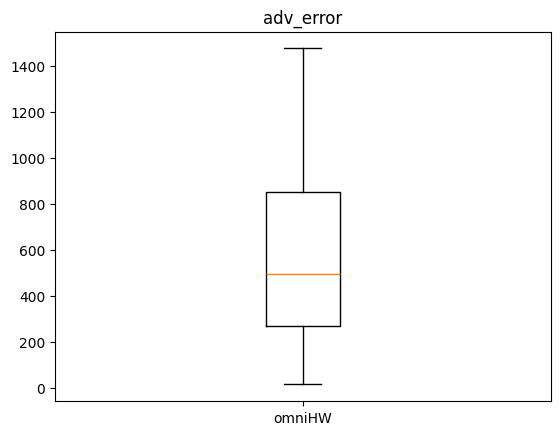

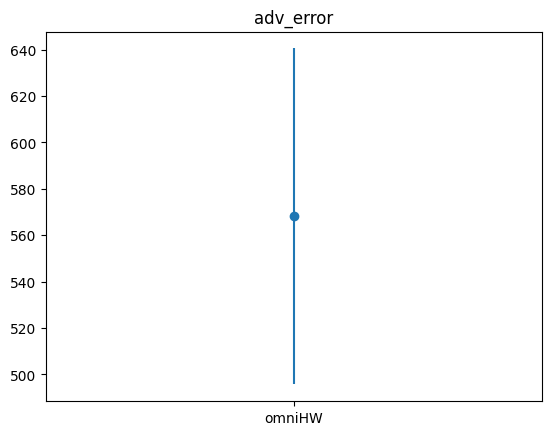

In [12]:
adv_error = pk.AdversaryError()
location_data = adv_error.execute(location_data)

plot_utils.boxplot(labels=[attack.ATTACK_ID], values=adv_error.values, title=adv_error.METRIC_ID, show=True)
plot_utils.plot_errorbar(x=[attack.ATTACK_ID], y=adv_error.values, title=adv_error.METRIC_ID, show=True)